# import necessary library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

# load dataset

In [2]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df[['v1', 'v2']]

In [3]:
df.columns = ['labels', 'texts']

# data exploratory

In [4]:
df.head()

,labels,texts
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df['labels'].value_counts()

ham     4825
spam     747
Name: labels, dtype: int64

In [6]:
df.isna().sum()

labels    0
texts     0
dtype: int64

# data preprocessing

In [7]:
df['spam'] = df['labels'].map({'ham': 0, 'spam': 1})
texts = df['texts'].values
labels = df['spam'].values

In [8]:
maxLength = max(map(lambda x: len(x), texts))
maxLength

910

# make tokenizer

In [9]:
maxWordInSeq = 1000
embedDim = 100

In [10]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(texts)
sequence = tokenizer.texts_to_sequences(texts)

In [11]:
word2Index = tokenizer.word_index
numWord = len(word2Index)
print(f'the total of unique tokens are {numWord}')

the total of unique tokens are 8920


# split datasets

In [12]:
data = keras.utils.pad_sequences(sequences=sequence, maxlen=maxWordInSeq, padding='post', truncating='post')
xTrain, xTest, yTrain, yTest = train_test_split(data, labels, train_size=0.8, random_state=42, stratify=labels)

# build algorithm

In [13]:
inputSeq = keras.layers.Input(shape=[maxWordInSeq, ], dtype='int32')
embedSeq = keras.layers.Embedding(numWord+1, embedDim, input_length=maxWordInSeq)(inputSeq)

conv_1 = keras.layers.Conv1D(32, 3, activation=keras.activations.relu)(embedSeq)
conv_1 = keras.layers.MaxPooling1D(pool_size=3)(conv_1)
conv_2 = keras.layers.Conv1D(64, 3, activation=keras.activations.relu)(conv_1)
conv_2 = keras.layers.MaxPooling1D(pool_size=3)(conv_2)
conv_3 = keras.layers.Conv1D(128, 3, activation=keras.activations.relu)(conv_2)
conv_3 = keras.layers.MaxPooling1D(pool_size=3)(conv_3)
flat = keras.layers.Flatten()(conv_3)
dense_flat = keras.layers.Dense(128, activation=keras.activations.relu)(flat)
dense = keras.layers.Dense(1, activation=keras.activations.sigmoid)(dense_flat)

model = keras.models.Model(inputSeq, dense)
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(), metrics=keras.metrics.Accuracy())

In [14]:
model.fit(x=xTrain, y=yTrain, epochs=10, validation_data=[xTest, yTest])

Epoch 1/10
140/140 [==============================] - 26s 161ms/step - loss: 0.2139 - accuracy: 0.0000e+00 - val_loss: 0.0479 - val_accuracy: 0.0000e+00
Epoch 2/10
140/140 [==============================] - 23s 166ms/step - loss: 0.0343 - accuracy: 0.0000e+00 - val_loss: 0.0452 - val_accuracy: 0.0000e+00
Epoch 3/10
140/140 [==============================] - 21s 150ms/step - loss: 0.0091 - accuracy: 0.0000e+00 - val_loss: 0.0491 - val_accuracy: 0.0000e+00
Epoch 4/10
140/140 [==============================] - 19s 135ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.1816 - val_accuracy: 0.0000e+00
Epoch 5/10
140/140 [==============================] - 18s 128ms/step - loss: 0.0038 - accuracy: 2.2437e-04 - val_loss: 0.0894 - val_accuracy: 0.0000e+00
Epoch 6/10
140/140 [==============================] - 20s 143ms/step - loss: 2.3595e-04 - accuracy: 4.4873e-04 - val_loss: 0.0815 - val_accuracy: 0.0018
Epoch 7/10
140/140 [==============================] - 27s 190ms/step - loss: 1.652

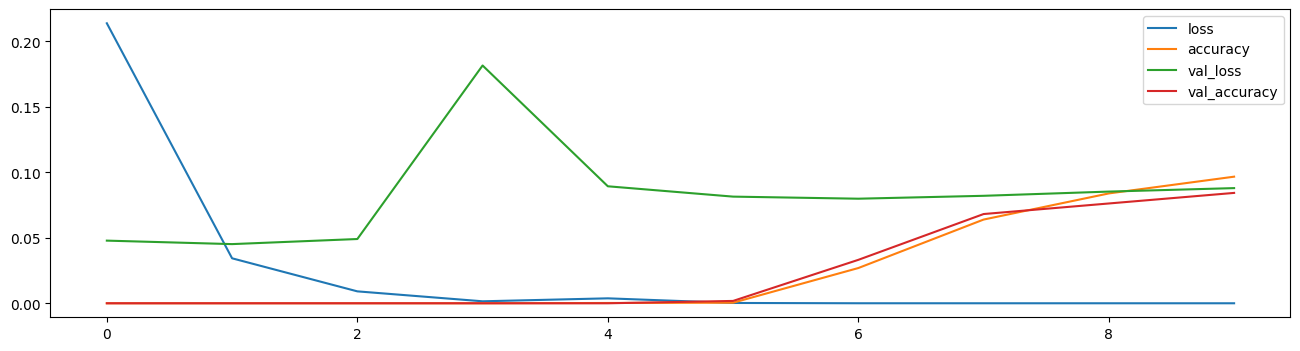

In [15]:
pd.DataFrame(model.history.history).plot(figsize=(16, 4))
plt.show()

In [16]:
prediction = (model.predict(xTest)).round()

35/35 [==============================] - 1s 29ms/step


# model evaluation

In [17]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

In [18]:
print(f'the accuracy of the model using test data is {accuracy_score(yTest, prediction)}')

the accuracy of the model using test data is 0.9874439461883409


In [19]:
print(classification_report(yTest, prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.98      0.93      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



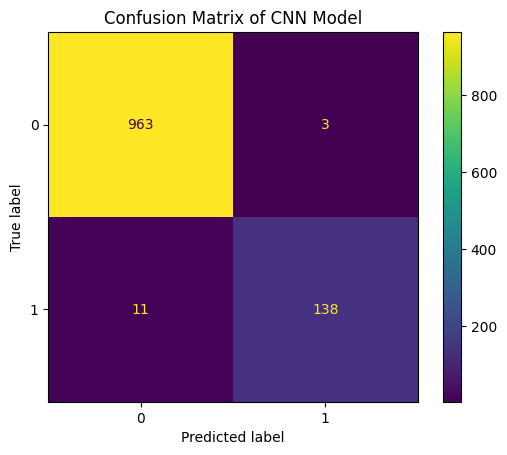

In [20]:
ConfusionMatrixDisplay.from_predictions(yTest, prediction)
plt.title('Confusion Matrix of CNN Model')
plt.show()